<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/). 
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA). 
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"


2.2.2


### Load MNIST Data

In [5]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.2
torchvision version: 0.17.2


In [6]:
train_data = datasets.MNIST(root="data",
                            train=True,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None
                            )
test_data = datasets.MNIST(root="data",
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:00<00:00, 10320074.78it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 390515.92it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3630602.64it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 7132358.21it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [11]:
class_names = train_data.classes

### Visualize training images

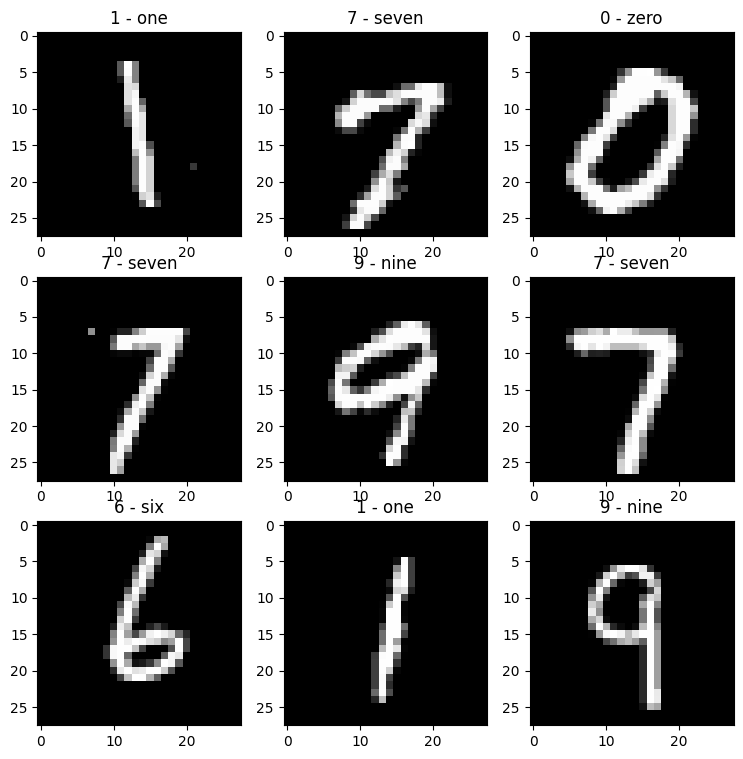

In [12]:
import random
fig = plt.figure(figsize=(9,9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    rand_idx = random.randint(0, len(train_data))
    img, label = train_data[rand_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])

### Create Dataloader objects

In [13]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


### Implement TinyVGG Model

In [21]:
class TinyVGG(nn.Module):

    def __init__(self, hidden_channels, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_channels,
                      out_channels=hidden_channels,
                      kernel_size=3,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classification_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*hidden_channels, out_features=num_classes)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classification_layer(x)

In [25]:
model = TinyVGG(hidden_channels=10, num_classes=len(class_names)).to(device=device)

### Write training loop

In [26]:
from tqdm.auto import tqdm

def train_one_epoch(model: nn.Module,
                    dataloader: torch.utils.data.DataLoader,
                    loss_fn: torch.nn.Module,
                    optimizer: torch.optim.Optimizer,
                    lr: float,
                    accuracy_fn,
                    device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    
    # Move model to device
    # model = model.to(device)

    # Set optimizer based on where model weights now live
    optimizer = optimizer(model.parameters(), lr=lr)

    model.train()

    for imgs, labels in dataloader:
        
        # Move data to device
        imgs, labels = imgs.to(device), labels.to(device)

        # Run forward pass on data
        img_logits = model(imgs)
        img_probs = torch.softmax(img_logits, dim=1)
        pred_labels = torch.argmax(img_probs, dim=1)

        # Compute loss and accuracy
        loss = loss_fn(img_logits, labels)
        train_loss += loss
        acc = accuracy_fn(y_pred=pred_labels, y_true=labels)
        train_acc += acc

        # Zero grads
        optimizer.zero_grad()

        # Backprop
        loss.backward()

        # Take optimizer step
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f}")


def test_eval(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
    test_loss, test_acc = 0, 0
    
    # Move model to device
    # model = model.to(device)

    model.eval()

    with torch.inference_mode():

        for imgs, labels in dataloader:
            
            # Move data to device
            imgs, labels = imgs.to(device), labels.to(device)

            # Run forward pass on data
            img_logits = model(imgs)
            img_probs = torch.softmax(img_logits, dim=1)
            pred_labels = torch.argmax(img_probs, dim=1)

            # Compute loss and accuracy
            loss = loss_fn(img_logits, labels)
            test_loss += loss
            acc = accuracy_fn(y_pred=pred_labels, y_true=labels)
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}")


In [27]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD

epochs = 3

for epoch in range(epochs):
    
    print(f"Beginning Epoch {epoch+1} Training")

    train_one_epoch(model=model,
                    dataloader=train_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    lr=0.1,
                    accuracy_fn=accuracy_fn,
                    device=device)
    test_eval(model=model,
              dataloader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)

Beginning Epoch 1 Training
Training Loss: 0.26388 | Training Accuracy: 91.27
Test Loss: 0.07484 | Test Accuracy: 97.60
Beginning Epoch 2 Training
Training Loss: 0.07100 | Training Accuracy: 97.76
Test Loss: 0.08223 | Test Accuracy: 97.36
Beginning Epoch 3 Training
Training Loss: 0.05629 | Training Accuracy: 98.27
Test Loss: 0.04551 | Test Accuracy: 98.48


### Visualize some predictions on test set

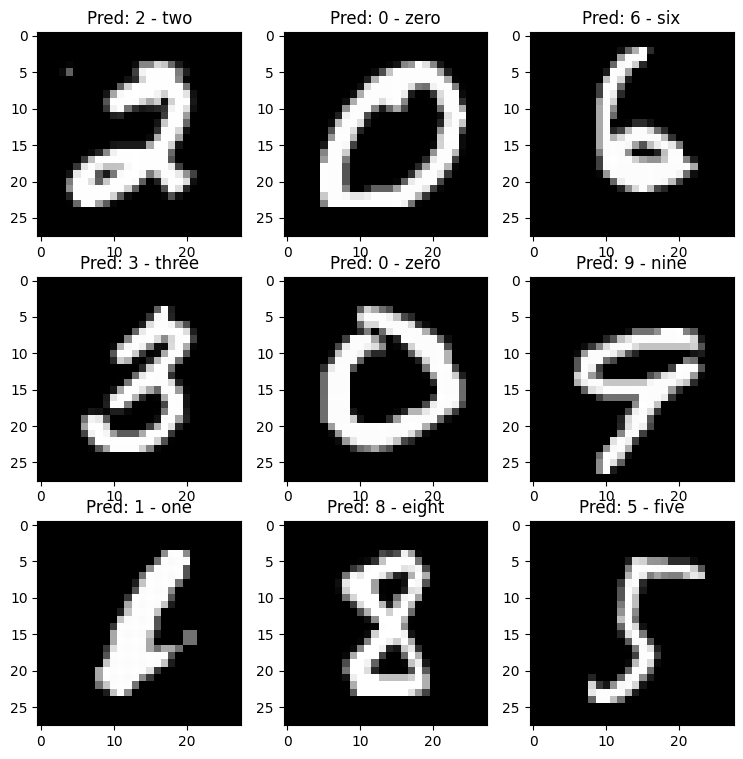

In [36]:
fig = plt.figure(figsize=(9,9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
    rand_idx = random.randint(0, len(test_data))
    img, label = test_data[rand_idx]
    pred_logits = model(img.unsqueeze(0).to(device)).cpu()
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_label = torch.argmax(pred_probs, dim=1).int().numpy().item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(f"Pred: {class_names[pred_label]}")